In [2]:
import os
os.chdir('../')

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def sample_pred_at_positions(pred, positions):
    r, c = positions[:, 0], positions[:, 1]
    r0, c0 = r.floor().long(), c.floor().long()
    r1, c1 = r0 + 1, c0 + 1
    dr, dc = (r - r0.float()).unsqueeze(1), (c - c0.float()).unsqueeze(1)
    H, W = pred.shape
    r0, r1 = r0.clamp(0, H - 1), r1.clamp(0, H - 1)
    c0, c1 = c0.clamp(0, W - 1), c1.clamp(0, W - 1)
    Ia, Ib = pred[r0, c0].unsqueeze(1), pred[r0, c1].unsqueeze(1)
    Ic, Id = pred[r1, c0].unsqueeze(1), pred[r1, c1].unsqueeze(1)
    val = (Ia * (1 - dr) * (1 - dc) +
           Ib * (1 - dr) * dc +
           Ic * dr * (1 - dc) +
           Id * dr * dc)
    return val.squeeze(1)

def compute_normals(sdf):
    H, W = sdf.shape
    grad_row, grad_col = torch.zeros_like(sdf), torch.zeros_like(sdf)
    sdf_smoothed = sdf  # add GaussianBlur here if you wish
    grad_row[1:-1] = (sdf_smoothed[2:] - sdf_smoothed[:-2]) * 0.5
    grad_col[:, 1:-1] = (sdf_smoothed[:, 2:] - sdf_smoothed[:, :-2]) * 0.5
    grad_row[0]  = sdf_smoothed[1] - sdf_smoothed[0]
    grad_row[-1] = sdf_smoothed[-1] - sdf_smoothed[-2]
    grad_col[:, 0]  = sdf_smoothed[:, 1] - sdf_smoothed[:, 0]
    grad_col[:, -1] = sdf_smoothed[:, -1] - sdf_smoothed[:, -2]
    return torch.stack([grad_row, grad_col], dim=2)  # (H,W,2)

def sample_normals_at_positions(normals, positions, normalize=True):
    H, W, _ = normals.shape
    r, c = positions[:, 0], positions[:, 1]
    r0, c0 = r.floor().long(), c.floor().long()
    r1, c1 = r0 + 1, c0 + 1
    dr, dc = (r - r0.float()).unsqueeze(1), (c - c0.float()).unsqueeze(1)
    r0, r1 = r0.clamp(0, H-1), r1.clamp(0, H-1)
    c0, c1 = c0.clamp(0, W-1), c1.clamp(0, W-1)
    Ia, Ib = normals[r0, c0], normals[r0, c1]
    Ic, Id = normals[r1, c0], normals[r1, c1]
    n_interp = (Ia * (1 - dr) * (1 - dc) +
                Ib * (1 - dr) * dc +
                Ic * dr * (1 - dc) +
                Id * dr * dc)
    if normalize:
        n_interp = n_interp / (torch.norm(n_interp, dim=1, keepdim=True) + 1e-8)
    return n_interp  # (N,2)

def extract_zero_crossings_interpolated_positions(sdf_tensor, requires_grad=False):
    eps, pos, H, W = 1e-8, [], *sdf_tensor.shape
    sdf_np = sdf_tensor.detach().cpu().numpy()
    # vertical neighbours
    for i in range(H-1):
        for j in range(W):
            v1, v2 = sdf_np[i, j], sdf_np[i+1, j]
            if v1 == 0:                pos.append([i, j])
            elif v2 == 0:              pos.append([i+1, j])
            elif v1 * v2 < 0:
                alpha = abs(v1) / (abs(v1) + abs(v2) + eps)
                pos.append([i + alpha, j])
    # horizontal neighbours
    for i in range(H):
        for j in range(W-1):
            v1, v2 = sdf_np[i, j], sdf_np[i, j+1]
            if v1 == 0:                pos.append([i, j])
            elif v2 == 0:              pos.append([i, j+1])
            elif v1 * v2 < 0:
                alpha = abs(v1) / (abs(v1) + abs(v2) + eps)
                pos.append([i, j + alpha])
    return (torch.tensor(pos, dtype=torch.float32, device=sdf_tensor.device,
                         requires_grad=requires_grad)
            if pos else
            torch.empty((0, 2), dtype=torch.float32, device=sdf_tensor.device,
                        requires_grad=requires_grad))

def compute_chamfer_distance(points1, points2):
    if points1.numel() == 0 or points2.numel() == 0:
        return torch.tensor(float('inf'), device=points1.device)
    dists = torch.norm(points1.unsqueeze(1) - points2.unsqueeze(0), dim=2)
    return -torch.min(dists, dim=1).values.mean() + torch.min(dists, dim=0).values.mean()

def manual_chamfer_grad(pred_sdf, pred_zc, gt_zc, update_scale=1.0, dist_threshold=3.0):
    dSDF = torch.zeros_like(pred_sdf)
    normals = compute_normals(pred_sdf)
    n_at_pts = sample_normals_at_positions(normals, pred_zc)  # (N,2)
    gt_cpu, pred_cpu = gt_zc.detach().cpu(), pred_zc.detach().cpu()
    for i, p in enumerate(pred_cpu):
        dists = torch.norm(gt_cpu - p, dim=1)
        min_dist, idx = torch.min(dists, dim=0)
        if min_dist > dist_threshold:  # ignore spurious prediction
            continue
        dl_dp = gt_cpu[idx] - p                       # (2,)
        n = n_at_pts[i] / (torch.norm(n_at_pts[i]) + 1e-8)
        dot_val = torch.dot(dl_dp.to(n.device), n) * update_scale
        r, c = p.tolist()
        r0, c0 = int(np.floor(r)), int(np.floor(c))
        r1, c1 = r0 + 1, c0 + 1
        w_r1, w_c1 = r - r0, c - c0
        w_r0, w_c0 = 1 - w_r1, 1 - w_c1
        H, W = dSDF.shape
        if 0 <= r0 < H and 0 <= c0 < W: dSDF[r0, c0] += dot_val * w_r0 * w_c0
        if 0 <= r0 < H and 0 <= c1 < W: dSDF[r0, c1] += dot_val * w_r0 * w_c1
        if 0 <= r1 < H and 0 <= c0 < W: dSDF[r1, c0] += dot_val * w_r1 * w_c0
        if 0 <= r1 < H and 0 <= c1 < W: dSDF[r1, c1] += dot_val * w_r1 * w_c1
    return dSDF



class ChamferBoundarySDFLoss(nn.Module):
    """
    Final loss =  pixel_weight * L1(pred, gt)  with an additional boundary
    gradient injected (chamfer_weight * manual_chamfer_grad).
    """

    def __init__(self,
                 pixel_weight: float   = 1.0,
                 chamfer_weight: float = 1.0,
                 update_scale: float   = 100.0,
                 dist_threshold: float = 1.5):
        super().__init__()
        self.pixel_w      = pixel_weight
        self.chamfer_w    = chamfer_weight
        self.update_scale = update_scale
        self.dist_thresh  = dist_threshold

    # ------------------------------------------------------------------ #
    def forward(self, pred_logits: torch.Tensor, gt_sdf: torch.Tensor) -> torch.Tensor:
        """
        pred_logits : (B,1,H,W)  raw UNet outputs (interpreted as SDF)
        gt_sdf      : (B,1,H,W) or (B,H,W)  ground‑truth SDF
        returns     : scalar loss
        """
        if pred_logits.ndim != 4 or pred_logits.size(1) != 1:
            raise ValueError("pred_logits must be (B,1,H,W)")
        pred_sdf = pred_logits[:, 0]          # (B,H,W)

        if gt_sdf.ndim == 4 and gt_sdf.size(1) == 1:
            gt_sdf = gt_sdf[:, 0]             # (B,H,W)
        elif gt_sdf.ndim != 3:
            raise ValueError("gt_sdf must be (B,1,H,W) or (B,H,W)")

        # 1) pixel loss (fully differentiable)
        pixel_loss = F.l1_loss(pred_sdf, gt_sdf)

        # 2) inject boundary gradient via register_hook
        chamfer_vals = []
        for b in range(pred_sdf.size(0)):
            psdf, gsdf = pred_sdf[b], gt_sdf[b]

            with torch.no_grad():
                gt_zc   = extract_zero_crossings_interpolated_positions(gsdf, False)
                pred_zc = extract_zero_crossings_interpolated_positions(psdf, True)

            dSDF = manual_chamfer_grad(psdf, pred_zc, gt_zc,
                                       update_scale=self.update_scale,
                                       dist_threshold=self.dist_thresh)

            psdf.register_hook(lambda g, d=dSDF: g + self.chamfer_w * d)
            chamfer_vals.append(compute_chamfer_distance(pred_zc, gt_zc))

        # 3) composite value (only pixel_loss contributes numerically)
        loss = self.pixel_w * pixel_loss

        # store for optional logging
        self.last_pixel   = pixel_loss.detach()
        self.last_chamfer = (torch.stack(chamfer_vals).mean().detach()
                             if chamfer_vals else torch.tensor(0.0))

        return loss


In [ ]:
# losses/chamfer_boundary_sdf.py
# ----------------------------------------------------------
# ChamferBoundarySDFLoss: top-tier, memory-safe, vectorized
# ----------------------------------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple


# ==========================================================
# Utility functions
# ==========================================================

def subsample_points(pts: torch.Tensor, max_points: int) -> torch.Tensor:
    """Randomly subsample points if they exceed max_points."""
    if pts.numel() == 0 or pts.size(0) <= max_points:
        return pts
    idx = torch.randperm(pts.size(0), device=pts.device)[:max_points]
    return pts[idx]


def chunked_min_pairwise(a: torch.Tensor,
                         b: torch.Tensor,
                         chunk: int = 2048) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute min pairwise distances a->b and b->a in chunks to avoid OOM.
    a: (Na,2), b: (Nb,2)
    Returns:
        mins_ab: (Na,)  each element is min distance from a[i] to any point in b
        mins_ba: (Nb,)  same but from b[j] to any point in a
    """
    if a.numel() == 0 or b.numel() == 0:
        dev = a.device if a.numel() else b.device
        na = a.size(0)
        nb = b.size(0)
        mins_ab = torch.full((na,), float('inf'), device=dev)
        mins_ba = torch.full((nb,), float('inf'), device=dev)
        return mins_ab, mins_ba

    mins_ab = []
    for s in range(0, a.size(0), chunk):
        d = torch.cdist(a[s:s + chunk], b)
        mins_ab.append(d.min(dim=1).values)
    mins_ab = torch.cat(mins_ab, dim=0)

    mins_ba = []
    for s in range(0, b.size(0), chunk):
        d = torch.cdist(b[s:s + chunk], a)
        mins_ba.append(d.min(dim=1).values)
    mins_ba = torch.cat(mins_ba, dim=0)

    return mins_ab, mins_ba


def bilinear_sample(image: torch.Tensor, pos: torch.Tensor) -> torch.Tensor:
    """
    Bilinear sample a 2D tensor image(H,W) at N floating positions pos(N,2).
    pos[:,0] = row (y), pos[:,1] = col (x).
    Returns (N,).
    """
    r, c = pos[:, 0], pos[:, 1]
    r0 = torch.floor(r).long()
    c0 = torch.floor(c).long()
    r1 = r0 + 1
    c1 = c0 + 1

    H, W = image.shape
    r0 = r0.clamp(0, H - 1)
    r1 = r1.clamp(0, H - 1)
    c0 = c0.clamp(0, W - 1)
    c1 = c1.clamp(0, W - 1)

    dr = (r - r0.float()).unsqueeze(1)
    dc = (c - c0.float()).unsqueeze(1)

    Ia = image[r0, c0].unsqueeze(1)
    Ib = image[r0, c1].unsqueeze(1)
    Ic = image[r1, c0].unsqueeze(1)
    Id = image[r1, c1].unsqueeze(1)

    val = (Ia * (1 - dr) * (1 - dc) +
           Ib * (1 - dr) * dc +
           Ic * dr * (1 - dc) +
           Id * dr * dc)
    return val.squeeze(1)


def finite_diff_normals(sdf: torch.Tensor) -> torch.Tensor:
    """
    Compute normals via central differences.
    sdf: (H,W)
    returns: (H,W,2) -> grad_row, grad_col
    """
    H, W = sdf.shape
    grad_row = torch.zeros_like(sdf)
    grad_col = torch.zeros_like(sdf)

    grad_row[1:-1] = (sdf[2:] - sdf[:-2]) * 0.5
    grad_col[:, 1:-1] = (sdf[:, 2:] - sdf[:, :-2]) * 0.5

    grad_row[0] = sdf[1] - sdf[0]
    grad_row[-1] = sdf[-1] - sdf[-2]
    grad_col[:, 0] = sdf[:, 1] - sdf[:, 0]
    grad_col[:, -1] = sdf[:, -1] - sdf[:, -2]

    return torch.stack([grad_row, grad_col], dim=2)


def bilinear_sample_normals(normals: torch.Tensor,
                            pos: torch.Tensor,
                            normalize: bool = True) -> torch.Tensor:
    """
    Bilinearly sample normals(H,W,2) at positions(N,2).
    returns (N,2).
    """
    H, W, _ = normals.shape
    r, c = pos[:, 0], pos[:, 1]
    r0 = torch.floor(r).long()
    c0 = torch.floor(c).long()
    r1 = r0 + 1
    c1 = c0 + 1

    r0 = r0.clamp(0, H - 1)
    r1 = r1.clamp(0, H - 1)
    c0 = c0.clamp(0, W - 1)
    c1 = c1.clamp(0, W - 1)

    dr = (r - r0.float()).unsqueeze(1)
    dc = (c - c0.float()).unsqueeze(1)

    Ia = normals[r0, c0]
    Ib = normals[r0, c1]
    Ic = normals[r1, c0]
    Id = normals[r1, c1]

    n = (Ia * (1 - dr) * (1 - dc) +
         Ib * (1 - dr) * dc +
         Ic * dr * (1 - dc) +
         Id * dr * dc)

    if normalize:
        n = n / (torch.norm(n, dim=1, keepdim=True) + 1e-8)
    return n


def extract_zero_crossings(sdf: torch.Tensor) -> torch.Tensor:
    """
    Fully vectorized zero-crossing extraction for a single 2D SDF image.
    sdf: (H,W)
    returns: (N,2) tensor of subpixel coordinates (row, col).
    """
    device = sdf.device
    dtype = sdf.dtype
    eps = 1e-8

    H, W = sdf.shape

    # vertical sign changes between rows
    v1 = sdf[:-1, :]     # (H-1,W)
    v2 = sdf[1:, :]      # (H-1,W)
    sign_change_v = (v1 * v2) < 0
    nonzero_v1 = (v1 == 0)
    nonzero_v2 = (v2 == 0)

    idx_v = sign_change_v.nonzero(as_tuple=False)
    # idx_v: (Nv, 2) -> [r, c] where r in [0,H-2]
    if idx_v.numel():
        r = idx_v[:, 0]
        c = idx_v[:, 1]
        a = torch.abs(v1[r, c])
        b = torch.abs(v2[r, c])
        alpha = a / (a + b + eps)
        rows = r.float() + alpha
        cols = c.float()
        vert_pts = torch.stack([rows, cols], dim=1)
    else:
        vert_pts = torch.empty((0, 2), device=device, dtype=dtype)

    # handle exact zero in vertical neighbors
    z_idx_v1 = nonzero_v1.nonzero(as_tuple=False)
    z_idx_v2 = nonzero_v2.nonzero(as_tuple=False)
    if z_idx_v1.numel():
        vert_zero1 = torch.stack([z_idx_v1[:, 0].float(),
                                  z_idx_v1[:, 1].float()], dim=1)
        vert_pts = torch.cat([vert_pts, vert_zero1], dim=0)
    if z_idx_v2.numel():
        vert_zero2 = torch.stack([z_idx_v2[:, 0].float() + 1,
                                  z_idx_v2[:, 1].float()], dim=1)
        vert_pts = torch.cat([vert_pts, vert_zero2], dim=0)

    # horizontal sign changes between columns
    h1 = sdf[:, :-1]     # (H,W-1)
    h2 = sdf[:,  1:]     # (H,W-1)
    sign_change_h = (h1 * h2) < 0
    nonzero_h1 = (h1 == 0)
    nonzero_h2 = (h2 == 0)

    idx_h = sign_change_h.nonzero(as_tuple=False)
    if idx_h.numel():
        r = idx_h[:, 0]
        c = idx_h[:, 1]
        a = torch.abs(h1[r, c])
        b = torch.abs(h2[r, c])
        alpha = a / (a + b + eps)
        rows = r.float()
        cols = c.float() + alpha
        horiz_pts = torch.stack([rows, cols], dim=1)
    else:
        horiz_pts = torch.empty((0, 2), device=device, dtype=dtype)

    # handle exact zero in horizontal neighbors
    z_idx_h1 = nonzero_h1.nonzero(as_tuple=False)
    z_idx_h2 = nonzero_h2.nonzero(as_tuple=False)
    if z_idx_h1.numel():
        horiz_zero1 = torch.stack([z_idx_h1[:, 0].float(),
                                   z_idx_h1[:, 1].float()], dim=1)
        horiz_pts = torch.cat([horiz_pts, horiz_zero1], dim=0)
    if z_idx_h2.numel():
        horiz_zero2 = torch.stack([z_idx_h2[:, 0].float(),
                                   z_idx_h2[:, 1].float() + 1], dim=1)
        horiz_pts = torch.cat([horiz_pts, horiz_zero2], dim=0)

    # concatenate and remove duplicates (optional)
    if vert_pts.numel() == 0 and horiz_pts.numel() == 0:
        return torch.empty((0, 2), device=device, dtype=dtype)

    pts = torch.cat([vert_pts, horiz_pts], dim=0)
    # optional uniqueness (could be expensive); usually fine without:
    # pts = torch.unique(torch.round(pts * 1000) / 1000, dim=0)

    return pts


def make_dSDF(pred_sdf: torch.Tensor,
              pred_zc: torch.Tensor,
              gt_zc: torch.Tensor,
              update_scale: float,
              dist_threshold: float,
              normalize_normals: bool,
              max_points: int,
              clip_val: Optional[float]) -> torch.Tensor:
    """
    Create the additive gradient field dSDF to be injected.
    """
    if pred_zc.numel() == 0 or gt_zc.numel() == 0:
        return torch.zeros_like(pred_sdf)

    # optional subsample for safety
    pred_zc = subsample_points(pred_zc, max_points)
    gt_zc   = subsample_points(gt_zc,   max_points)

    normals = finite_diff_normals(pred_sdf)
    n_at_pts = bilinear_sample_normals(normals, pred_zc, normalize=normalize_normals)

    # Compute nearest GT point for each pred point
    # We'll do it chunked:
    device = pred_sdf.device
    dSDF = torch.zeros_like(pred_sdf)

    # Move pred_zc to CPU for loop? We keep it on GPU; we only iterate minimal times
    # but do operations in vectorized chunk fashion:
    chunk = 2048
    for s in range(0, pred_zc.size(0), chunk):
        p_chunk = pred_zc[s:s + chunk]          # (C,2)
        n_chunk = n_at_pts[s:s + chunk]         # (C,2)
        dist = torch.cdist(p_chunk, gt_zc)      # (C, G)
        min_dist, idx = dist.min(dim=1)         # (C,)
        mask = min_dist <= dist_threshold
        if not mask.any():
            continue

        valid_p = p_chunk[mask]
        valid_n = n_chunk[mask]
        valid_g = gt_zc[idx[mask]]

        # direction from pred to gt
        dl_dp = (valid_g - valid_p)             # (M,2)
        if normalize_normals:
            valid_n = valid_n / (torch.norm(valid_n, dim=1, keepdim=True) + 1e-8)

        dot_val = torch.sum(dl_dp * valid_n, dim=1) * update_scale  # (M,)

        # scatter into dSDF with bilinear weights
        r = valid_p[:, 0]
        c = valid_p[:, 1]
        r0 = torch.floor(r).long().clamp(0, pred_sdf.shape[0] - 1)
        c0 = torch.floor(c).long().clamp(0, pred_sdf.shape[1] - 1)
        r1 = (r0 + 1).clamp(0, pred_sdf.shape[0] - 1)
        c1 = (c0 + 1).clamp(0, pred_sdf.shape[1] - 1)

        dr = (r - r0.float())
        dc = (c - c0.float())
        w00 = (1 - dr) * (1 - dc)
        w01 = (1 - dr) * dc
        w10 = dr * (1 - dc)
        w11 = dr * dc

        # accumulation
        dSDF.index_put_((r0, c0), dot_val * w00, accumulate=True)
        dSDF.index_put_((r0, c1), dot_val * w01, accumulate=True)
        dSDF.index_put_((r1, c0), dot_val * w10, accumulate=True)
        dSDF.index_put_((r1, c1), dot_val * w11, accumulate=True)

    if clip_val is not None:
        dSDF = torch.clamp(dSDF, -clip_val, clip_val)

    return dSDF


# ==========================================================
# Main loss
# ==========================================================

class ChamferBoundarySDFLoss(nn.Module):
    """
    Final loss = pixel_weight * L1(pred_sdf, gt_sdf).

    Additionally, a custom gradient term (dSDF) is injected during backward
    to align the predicted zero-level set to the ground truth boundary.

    Parameters
    ----------
    pixel_weight       : weight of the pixel L1 term
    chamfer_weight     : scales the injected gradient (hook)
    update_scale       : multiplier inside dSDF construction
    dist_threshold     : maximum distance (in px) to consider for Chamfer pairing
    max_points         : subsample count of zero-crossing points (pred & gt)
    normalize_normals  : normalize normals before dot product
    use_hook           : True => inject gradient via register_hook
    clip_sdf_to        : clamp both pred and gt SDF to [lo,hi] before loss
    clip_dSDF          : clamp dSDF values to [-clip_dSDF, +clip_dSDF]
    warmup_factor      : 0..1 external scalar to scale chamfer_weight (set with set_epoch or manually)
    """

    def __init__(self,
                 pixel_weight: float = 1.0,
                 chamfer_weight: float = 1.0,
                 update_scale: float = 100.0,
                 dist_threshold: float = 1.0,
                 max_points: int = 4096,
                 normalize_normals: bool = True,
                 use_hook: bool = True,
                 clip_sdf_to: Optional[Tuple[float, float]] = None,
                 clip_dSDF: Optional[float] = 1.0):
        super().__init__()
        self.pixel_weight = pixel_weight
        self.chamfer_weight = chamfer_weight
        self.update_scale = update_scale
        self.dist_threshold = dist_threshold
        self.max_points = max_points
        self.normalize_normals = normalize_normals
        self.use_hook = use_hook
        self.clip_sdf_to = clip_sdf_to
        self.clip_dSDF = clip_dSDF

        self._warmup = 1.0  # external multiplier you can change per epoch

        # Logging holders
        self.last_pixel = torch.tensor(0.0)
        self.last_chamfer = torch.tensor(0.0)

    # Optional: allow external warmup control
    def set_warmup_factor(self, factor: float):
        self._warmup = float(factor)

    def forward(self, pred_logits: torch.Tensor, gt_sdf: torch.Tensor) -> torch.Tensor:
        """
        pred_logits: (B,1,H,W) raw network output interpreted as SDF
        gt_sdf     : (B,1,H,W) or (B,H,W)
        """
        if pred_logits.ndim != 4 or pred_logits.size(1) != 1:
            raise ValueError("pred_logits must be (B,1,H,W)")

        pred_sdf = pred_logits[:, 0]  # (B,H,W)
        if gt_sdf.ndim == 4 and gt_sdf.size(1) == 1:
            gt_sdf = gt_sdf[:, 0]
        elif gt_sdf.ndim != 3:
            raise ValueError("gt_sdf must be (B,1,H,W) or (B,H,W)")

        if self.clip_sdf_to is not None:
            lo, hi = self.clip_sdf_to
            pred_sdf = pred_sdf.clamp(lo, hi)
            gt_sdf = gt_sdf.clamp(lo, hi)

        # Pixel-wise L1
        pixel_loss = F.l1_loss(pred_sdf, gt_sdf)

        chamfer_vals = []
        if self.use_hook and self._warmup > 0 and self.chamfer_weight > 0:
            # build dSDF per image and attach hook
            for b in range(pred_sdf.size(0)):
                psdf = pred_sdf[b]
                gsdf = gt_sdf[b]

                with torch.no_grad():
                    gt_zc = subsample_points(extract_zero_crossings(gsdf), self.max_points)
                    pred_zc = subsample_points(extract_zero_crossings(psdf), self.max_points)

                # Only for logging
                if pred_zc.numel() and gt_zc.numel():
                    d_ab, d_ba = chunked_min_pairwise(pred_zc, gt_zc)
                    chamfer_vals.append(-d_ab.mean() + d_ba.mean())
                else:
                    chamfer_vals.append(psdf.new_tensor(0.0))

                if pred_zc.numel() and gt_zc.numel():
                    dSDF = make_dSDF(psdf,
                                     pred_zc,
                                     gt_zc,
                                     update_scale=self.update_scale,
                                     dist_threshold=self.dist_threshold,
                                     normalize_normals=self.normalize_normals,
                                     max_points=self.max_points,
                                     clip_val=self.clip_dSDF)

                    # Inject gradient
                    def _hook(grad, d=dSDF):
                        return grad + self._warmup * self.chamfer_weight * d

                    psdf.register_hook(_hook)
        else:
            # no hook => chamfer_vals still trackable for logs but not used
            chamfer_vals = [pred_sdf.new_tensor(0.0) for _ in range(pred_sdf.size(0))]

        self.last_pixel = pixel_loss.detach()
        self.last_chamfer = torch.stack(chamfer_vals).mean().detach()

        return self.pixel_weight * pixel_loss


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from typing import Optional, Tuple

# ─────────────────────────────────────────────────────────────────────────────
# Utility functions (vectorized, GPU/CPU agnostic)
# ─────────────────────────────────────────────────────────────────────────────

def subsample_points(pts: torch.Tensor, max_points: int) -> torch.Tensor:
    """Randomly subsample points if they exceed max_points."""
    if pts.numel() == 0 or pts.size(0) <= max_points:
        return pts
    idx = torch.randperm(pts.size(0), device=pts.device)[:max_points]
    return pts[idx]


def chunked_min_pairwise(a: torch.Tensor,
                         b: torch.Tensor,
                         chunk: int = 2048) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute min pairwise distances a->b and b->a in chunks to avoid OOM.
    a: (Na,2), b: (Nb,2)
    Returns:
        mins_ab: (Na,) each element is min distance from a[i] to any point in b
        mins_ba: (Nb,) each element is min distance from b[j] to any point in a
    """
    if a.numel() == 0 or b.numel() == 0:
        dev = a.device if a.numel() else b.device
        na = a.size(0)
        nb = b.size(0)
        return (torch.full((na,), float('inf'), device=dev),
                torch.full((nb,), float('inf'), device=dev))

    mins_ab = []
    for s in range(0, a.size(0), chunk):
        d = torch.cdist(a[s:s + chunk], b)
        mins_ab.append(d.min(dim=1).values)
    mins_ab = torch.cat(mins_ab, dim=0)

    mins_ba = []
    for s in range(0, b.size(0), chunk):
        d = torch.cdist(b[s:s + chunk], a)
        mins_ba.append(d.min(dim=1).values)
    mins_ba = torch.cat(mins_ba, dim=0)
    return mins_ab, mins_ba


def finite_diff_normals(sdf: torch.Tensor) -> torch.Tensor:
    """Compute normals via central differences. sdf: (H,W) -> returns (H,W,2)."""
    H, W = sdf.shape
    grad_row = torch.zeros_like(sdf)
    grad_col = torch.zeros_like(sdf)

    grad_row[1:-1] = (sdf[2:] - sdf[:-2]) * 0.5
    grad_col[:, 1:-1] = (sdf[:, 2:] - sdf[:, :-2]) * 0.5

    grad_row[0] = sdf[1] - sdf[0]
    grad_row[-1] = sdf[-1] - sdf[-2]
    grad_col[:, 0] = sdf[:, 1] - sdf[:, 0]
    grad_col[:, -1] = sdf[:, -1] - sdf[:, -2]

    return torch.stack([grad_row, grad_col], dim=2)


def bilinear_sample_normals(normals: torch.Tensor,
                            pos: torch.Tensor,
                            normalize: bool = True) -> torch.Tensor:
    """
    Bilinearly sample normals(H,W,2) at positions(N,2) -> (N,2).
    pos[:,0]=row, pos[:,1]=col (y, x).
    """
    H, W, _ = normals.shape
    r, c = pos[:, 0], pos[:, 1]
    r0 = torch.floor(r).long().clamp(0, H - 1)
    c0 = torch.floor(c).long().clamp(0, W - 1)
    r1 = (r0 + 1).clamp(0, H - 1)
    c1 = (c0 + 1).clamp(0, W - 1)

    dr = (r - r0.float()).unsqueeze(1)
    dc = (c - c0.float()).unsqueeze(1)

    Ia = normals[r0, c0]
    Ib = normals[r0, c1]
    Ic = normals[r1, c0]
    Id = normals[r1, c1]

    n = (Ia * (1 - dr) * (1 - dc) +
         Ib * (1 - dr) * dc +
         Ic * dr * (1 - dc) +
         Id * dr * dc)

    if normalize:
        n = n / (torch.norm(n, dim=1, keepdim=True) + 1e-8)
    return n


def extract_zero_crossings(sdf: torch.Tensor) -> torch.Tensor:
    """
    Fully vectorized zero-crossing extraction for a single 2D SDF image.
    sdf: (H,W)
    returns: (N,2) tensor of subpixel coordinates (row, col).
    """
    device = sdf.device
    dtype = sdf.dtype
    eps = 1e-8
    H, W = sdf.shape

    # vertical
    v1, v2 = sdf[:-1, :], sdf[1:, :]
    sign_change_v = (v1 * v2) < 0
    idx_v = sign_change_v.nonzero(as_tuple=False)
    if idx_v.numel():
        r = idx_v[:, 0]
        c = idx_v[:, 1]
        a = torch.abs(v1[r, c])
        b = torch.abs(v2[r, c])
        alpha = a / (a + b + eps)
        rows = r.float() + alpha
        cols = c.float()
        vert_pts = torch.stack([rows, cols], dim=1)
    else:
        vert_pts = torch.empty((0, 2), device=device, dtype=dtype)

    # zeros on vertical
    z_idx_v1 = (v1 == 0).nonzero(as_tuple=False)
    z_idx_v2 = (v2 == 0).nonzero(as_tuple=False)
    if z_idx_v1.numel():
        vert_pts = torch.cat([vert_pts,
                              torch.stack([z_idx_v1[:, 0].float(),
                                           z_idx_v1[:, 1].float()], dim=1)], dim=0)
    if z_idx_v2.numel():
        vert_pts = torch.cat([vert_pts,
                              torch.stack([z_idx_v2[:, 0].float() + 1,
                                           z_idx_v2[:, 1].float()], dim=1)], dim=0)

    # horizontal
    h1, h2 = sdf[:, :-1], sdf[:, 1:]
    sign_change_h = (h1 * h2) < 0
    idx_h = sign_change_h.nonzero(as_tuple=False)
    if idx_h.numel():
        r = idx_h[:, 0]
        c = idx_h[:, 1]
        a = torch.abs(h1[r, c])
        b = torch.abs(h2[r, c])
        alpha = a / (a + b + eps)
        rows = r.float()
        cols = c.float() + alpha
        horiz_pts = torch.stack([rows, cols], dim=1)
    else:
        horiz_pts = torch.empty((0, 2), device=device, dtype=dtype)

    # zeros on horizontal
    z_idx_h1 = (h1 == 0).nonzero(as_tuple=False)
    z_idx_h2 = (h2 == 0).nonzero(as_tuple=False)
    if z_idx_h1.numel():
        horiz_pts = torch.cat([horiz_pts,
                               torch.stack([z_idx_h1[:, 0].float(),
                                            z_idx_h1[:, 1].float()], dim=1)], dim=0)
    if z_idx_h2.numel():
        horiz_pts = torch.cat([horiz_pts,
                               torch.stack([z_idx_h2[:, 0].float(),
                                            z_idx_h2[:, 1].float() + 1], dim=1)], dim=0)

    if vert_pts.numel() == 0 and horiz_pts.numel() == 0:
        return torch.empty((0, 2), device=device, dtype=dtype)

    pts = torch.cat([vert_pts, horiz_pts], dim=0)
    return pts


def make_dSDF(pred_sdf: torch.Tensor,
              pred_zc: torch.Tensor,
              gt_zc: torch.Tensor,
              update_scale: float,
              dist_threshold: float,
              normalize_normals: bool,
              max_points: int,
              clip_val: Optional[float]) -> torch.Tensor:
    """
    Create the additive gradient field dSDF to be injected.
    NOTE: designed to run on CPU in this implementation.
    """
    if pred_zc.numel() == 0 or gt_zc.numel() == 0:
        return torch.zeros_like(pred_sdf)

    pred_zc = subsample_points(pred_zc, max_points)
    gt_zc   = subsample_points(gt_zc,   max_points)

    normals = finite_diff_normals(pred_sdf)
    n_at_pts = bilinear_sample_normals(normals, pred_zc, normalize=normalize_normals)

    dSDF = torch.zeros_like(pred_sdf)

    chunk = 2048
    for s in range(0, pred_zc.size(0), chunk):
        p_chunk = pred_zc[s:s + chunk]
        n_chunk = n_at_pts[s:s + chunk]
        dist = torch.cdist(p_chunk, gt_zc)
        min_dist, idx = dist.min(dim=1)
        mask = min_dist <= dist_threshold
        if not mask.any():
            continue

        valid_p = p_chunk[mask]
        valid_n = n_chunk[mask]
        valid_g = gt_zc[idx[mask]]

        dl_dp = (valid_g - valid_p)
        if normalize_normals:
            valid_n = valid_n / (torch.norm(valid_n, dim=1, keepdim=True) + 1e-8)

        dot_val = torch.sum(dl_dp * valid_n, dim=1) * update_scale  # (M,)

        r = valid_p[:, 0]
        c = valid_p[:, 1]
        r0 = torch.floor(r).long().clamp(0, pred_sdf.shape[0] - 1)
        c0 = torch.floor(c).long().clamp(0, pred_sdf.shape[1] - 1)
        r1 = (r0 + 1).clamp(0, pred_sdf.shape[0] - 1)
        c1 = (c0 + 1).clamp(0, pred_sdf.shape[1] - 1)

        dr = (r - r0.float())
        dc = (c - c0.float())
        w00 = (1 - dr) * (1 - dc)
        w01 = (1 - dr) * dc
        w10 = dr * (1 - dc)
        w11 = dr * dc

        incr00 = (dot_val * w00)
        incr01 = (dot_val * w01)
        incr10 = (dot_val * w10)
        incr11 = (dot_val * w11)

        dSDF.index_put_((r0, c0), incr00, accumulate=True)
        dSDF.index_put_((r0, c1), incr01, accumulate=True)
        dSDF.index_put_((r1, c0), incr10, accumulate=True)
        dSDF.index_put_((r1, c1), incr11, accumulate=True)

    if clip_val is not None:
        dSDF = torch.clamp(dSDF, -clip_val, clip_val)

    return dSDF


# ─────────────────────────────────────────────────────────────────────────────
# Custom autograd Function (CPU heavy work, GPU-friendly gradient)
# ─────────────────────────────────────────────────────────────────────────────

class ChamferZeroSet(Function):
    @staticmethod
    def forward(ctx,
                pred_sdf: torch.Tensor,
                gt_sdf: torch.Tensor,
                dist_thresh: float,
                max_pts: int,
                update_scale: float,
                normalize_normals: bool = True,
                clip_dSDF: Optional[float] = None):
        """
        Computes a Chamfer-like distance between zero-level sets of pred_sdf and gt_sdf.
        Heavy stuff is done on CPU; returns scalar loss on GPU.
        """
        # Detach to avoid growing graph, move to CPU for heavy ops
        ps = pred_sdf.detach().cpu()
        gs = gt_sdf.detach().cpu()

        p_pts = subsample_points(extract_zero_crossings(ps), max_pts)
        g_pts = subsample_points(extract_zero_crossings(gs), max_pts)

        if p_pts.numel() == 0 or g_pts.numel() == 0:
            # nothing to do, chamfer loss = 0
            ctx.save_for_backward(torch.tensor([]))  # sentinel
            return pred_sdf.new_zeros(())

        # small CPU chamfer
        mins_pg, mins_gp = chunked_min_pairwise(p_pts, g_pts, chunk=2048)
        loss = (mins_pg.mean() + mins_gp.mean()).to(pred_sdf.device, dtype=pred_sdf.dtype)

        # Save everything needed for backward
        ctx.save_for_backward(pred_sdf, gt_sdf,
                              p_pts.to(pred_sdf.device),
                              g_pts.to(pred_sdf.device))
        ctx.dist_thresh = dist_thresh
        ctx.max_pts = max_pts
        ctx.update_scale = update_scale
        ctx.normalize_normals = normalize_normals
        ctx.clip_dSDF = clip_dSDF
        return loss

    @staticmethod
    def backward(ctx, grad_out):
        saved = ctx.saved_tensors
        # sentinel check: if zero points, return zero grad
        if len(saved) == 1:
            return (grad_out.new_zeros(1, *grad_out.shape[1:]).squeeze(),  # pred_sdf
                    None, None, None, None, None, None)

        pred_sdf, gt_sdf, p_pts, g_pts = saved
        dist_thresh = ctx.dist_thresh
        update_scale = ctx.update_scale
        normalize_normals = ctx.normalize_normals
        clip_dSDF = ctx.clip_dSDF

        # Build dSDF on CPU
        dSDF_cpu = make_dSDF(
            pred_sdf.detach().cpu(),
            p_pts.detach().cpu(),
            g_pts.detach().cpu(),
            update_scale=update_scale,
            dist_threshold=dist_thresh,
            normalize_normals=normalize_normals,
            max_points=p_pts.shape[0],
            clip_val=clip_dSDF
        )

        # Send only grad to GPU
        dSDF = dSDF_cpu.to(device=pred_sdf.device, dtype=pred_sdf.dtype)
        grad_pred = grad_out * dSDF  # chain rule

        # No grads for other args (constants / GT)
        return grad_pred, None, None, None, None, None, None


# ─────────────────────────────────────────────────────────────────────────────
# Main Loss
# ─────────────────────────────────────────────────────────────────────────────

class ChamferBoundarySDFLoss(nn.Module):
    """
    Pixel L1 (pred_sdf vs gt_sdf) + Chamfer distance between SDF zero-level sets.
    Chamfer part is implemented via a custom autograd function (no hooks).
    """

    def __init__(self,
                 pixel_weight: float = 1.0,
                 chamfer_weight: float = 1.0,
                 update_scale: float = 10.0,
                 dist_threshold: float = 2.0,
                 max_points: int = 2048,
                 normalize_normals: bool = True,
                 clip_sdf_to: Optional[Tuple[float, float]] = None,
                 clip_dSDF: Optional[float] = None,
                 downsample_factor: int = 1):
        super().__init__()
        self.pixel_weight = pixel_weight
        self.chamfer_weight = chamfer_weight

        self.update_scale = update_scale
        self.dist_threshold = dist_threshold
        self.max_points = max_points
        self.normalize_normals = normalize_normals
        self.clip_sdf_to = clip_sdf_to
        self.clip_dSDF = clip_dSDF
        self.downsample_factor = downsample_factor

        self._warmup = 1.0  # external scalar to scale chamfer_weight
        self.last_pixel = torch.tensor(0.0)
        self.last_chamfer = torch.tensor(0.0)

    def set_warmup_factor(self, factor: float):
        self._warmup = float(factor)

    def _maybe_downsample(self, x: torch.Tensor) -> torch.Tensor:
        if self.downsample_factor <= 1:
            return x
        # simple avgpool downsample (keep it differentiable if used outside Function)
        k = self.downsample_factor
        return F.avg_pool2d(x, kernel_size=k, stride=k)

    def forward(self, pred_logits: torch.Tensor, gt_sdf: torch.Tensor) -> torch.Tensor:
        """
        pred_logits: (B,1,H,W) raw net output interpreted as SDF
        gt_sdf     : (B,1,H,W) or (B,H,W)
        Returns scalar loss.
        """
        if pred_logits.ndim != 4 or pred_logits.size(1) != 1:
            raise ValueError("pred_logits must be (B,1,H,W)")

        pred_sdf = pred_logits[:, 0]  # (B,H,W)
        if gt_sdf.ndim == 4 and gt_sdf.size(1) == 1:
            gt_sdf = gt_sdf[:, 0]     # (B,H,W)
        elif gt_sdf.ndim != 3:
            raise ValueError("gt_sdf must be (B,1,H,W) or (B,H,W)")

        if self.clip_sdf_to is not None:
            lo, hi = self.clip_sdf_to
            pred_sdf = pred_sdf.clamp(lo, hi)
            gt_sdf   = gt_sdf.clamp(lo, hi)

        # Pixelwise L1
        pixel_loss = F.l1_loss(pred_sdf, gt_sdf)

        # Chamfer zero-set term
        chamfer_loss_list = []
        if self.chamfer_weight > 0 and self._warmup > 0:
            # Work per-batch item
            for b in range(pred_sdf.size(0)):
                ps = pred_sdf[b]
                gs = gt_sdf[b]

                # Optionally downsample to speed up Chamfer
                if self.downsample_factor > 1:
                    ps_ds = self._maybe_downsample(ps.unsqueeze(0)).squeeze(0)
                    gs_ds = self._maybe_downsample(gs.unsqueeze(0)).squeeze(0)
                else:
                    ps_ds, gs_ds = ps, gs

                chamfer_loss_list.append(
                    ChamferZeroSet.apply(
                        ps_ds.float(), gs_ds.float(),
                        float(self.dist_threshold),
                        int(self.max_points),
                        float(self.update_scale),
                        bool(self.normalize_normals),
                        None if self.clip_dSDF is None else float(self.clip_dSDF)
                    )
                )

            chamfer_loss = torch.stack(chamfer_loss_list).mean()
        else:
            chamfer_loss = pred_sdf.new_zeros(())

        self.last_pixel   = pixel_loss.detach()
        self.last_chamfer = chamfer_loss.detach()

        total = (self.pixel_weight * pixel_loss +
                 self.chamfer_weight * self._warmup * chamfer_loss)
        return total


In [4]:
# Notebook cell 1: setup and imports
%matplotlib inline
import os
import gc
import torch
import matplotlib.pyplot as plt
# from IPython.display import clear_output
from torch.utils.data import DataLoader

from core.general_dataset.base import GeneralizedDataset
from core.general_dataset.collate import worker_init_fn
from core.utils import yaml_read
from models.base_models import UNet
from metrics.apls import APLS

# ─────────────────────────────────────────────────────────────────────────────
# Configuration
# ─────────────────────────────────────────────────────────────────────────────
DATASET_YAML = "./configs/dataset/mass_test.yaml"
MODEL_YAML   = "./configs/model/baseline.yaml"
CKPT_IN      = "/home/ri/Desktop/Projects/Codebase/AllFayzad/sdf-first-run/outputs/checkpoints/last.ckpt"

BATCH_SIZE   = 1       # effective batch size
NUM_EPOCHS   = 100     # total epochs
LR           = 1e-4    # learning rate
LOG_EVERY    = 1       # log every N batches
PLOT_EVERY   = 1       # inline-plot every N epochs
NUM_WORKERS  = 4       # DataLoader num_workers

CROP_H = 512
CROP_W = 512
# ─────────────────────────────────────────────────────────────────────────────
# Helper to tweak YAML config per split
# ─────────────────────────────────────────────────────────────────────────────
def make_cfg(cfg, split):
    c = cfg.copy()
    c["split"] = split
    if split in ("valid", "test"):
        c["augmentations"] = []
    return c

def center_crop(x: torch.Tensor, crop_h: int, crop_w: int) -> torch.Tensor:
    """
    Center‑crop a batched 4‑D tensor x=(B,C,H,W) to size (B, C, crop_h, crop_w).
    Assumes crop_h <= H and crop_w <= W.
    """
    _, _, H, W = x.shape
    top  = (H - crop_h) // 2
    left = (W - crop_w) // 2
    return x[:, :, top:top+crop_h, left:left+crop_w]
# ─────────────────────────────────────────────────────────────────────────────
# Device
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# Dataset & DataLoader
# ─────────────────────────────────────────────────────────────────────────────
raw_cfg  = yaml_read(DATASET_YAML)
train_ds = GeneralizedDataset(make_cfg(raw_cfg, "train"))
train_dl = DataLoader(
    train_ds,
    batch_size=1,      # load one sample per iteration
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    worker_init_fn=worker_init_fn,
)
print(f"Loaded {len(train_ds)} training samples.")

# ─────────────────────────────────────────────────────────────────────────────
# Model instantiation
# ─────────────────────────────────────────────────────────────────────────────
model_cfg = yaml_read(MODEL_YAML)
model     = UNet(**model_cfg["params"]).to(device)

if os.path.isfile(CKPT_IN):
    print("Loading checkpoint:", CKPT_IN)
    ckpt_blob = torch.load(CKPT_IN, map_location=device)
    state     = ckpt_blob.get("state_dict", ckpt_blob)
    state     = {k.replace("model.", ""): v for k, v in state.items()}
    state     = {k: v for k, v in state.items() if k in model.state_dict()}
    model.load_state_dict(state, strict=False)
    print(f"Loaded {len(state)} parameter tensors from checkpoint.")

# ─────────────────────────────────────────────────────────────────────────────
# Loss, metric, optimizer
# ─────────────────────────────────────────────────────────────────────────────
loss_fn = ChamferBoundarySDFLoss(
    pixel_weight=1.0,
    chamfer_weight=1.0,
    update_scale=1.0,
    dist_threshold=1.5,
).to(device)

apls_fn  = APLS(
    data_dim=2, threshold=0.5, angle_range=(135,225),
    max_nodes=1000, max_snap_dist=4, allow_renaming=True,
    min_path_length=10, greater_is_road=True,
)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ─────────────────────────────────────────────────────────────────────────────
# Training loop with inline plotting (no AMP)
# ─────────────────────────────────────────────────────────────────────────────
global_step = 0

for epoch in range(1, NUM_EPOCHS + 1):
    if hasattr(train_ds, "set_epoch"):
        train_ds.set_epoch(epoch)

    model.train()
    running_loss = 0.0
    running_apls = 0.0

    for batch_idx, batch in enumerate(train_dl, start=1):
        x = batch["image_patch"]
        y = batch["sdf_patch"]

        # center‑crop both so H, W are divisible by 16
        x = center_crop(x, CROP_H, CROP_W)
        y = center_crop(y, CROP_H, CROP_W)

        print('y min', y.min())
        # now move to device
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        logits = model(x)
        loss   = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs      = torch.sigmoid(logits)
            batch_apls = apls_fn(probs, y)

        running_loss += loss.item()
        running_apls += batch_apls.item()
        global_step  += 1

        if batch_idx % LOG_EVERY == 0:
            print(
                f"Epoch {epoch:03d} | "
                f"Batch {batch_idx:04d}/{len(train_dl):04d} | "
                f"Loss {running_loss/batch_idx:.4f} | "
                f"APLS {running_apls/batch_idx:.4f}"
            )

    epoch_loss = running_loss / len(train_dl)
    epoch_apls = running_apls / len(train_dl)
    print(
        f"===> Epoch {epoch:03d} complete | "
        f"Avg Loss {epoch_loss:.4f} | Avg APLS {epoch_apls:.4f}"
    )

    # inline plotting in notebook
    if epoch % PLOT_EVERY == 0:
        # clear_output(wait=True)
        model.eval()
        with torch.no_grad():
            pred_sdf = logits[0, 0].cpu().numpy()
            gt_sdf   = y[0, 0].cpu().numpy()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.imshow(gt_sdf, cmap='viridis')
        ax1.set_title(f'Epoch {epoch}: GT SDF')
        ax2.imshow(pred_sdf, cmap='viridis')
        ax2.set_title(f'Epoch {epoch}: Predicted SDF')
        plt.tight_layout()
        plt.show()

    torch.cuda.empty_cache()
    gc.collect()


Using device: cuda
→ Split 'train': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
→ Split 'valid': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
→ Split 'test': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
Saved index for split 'train' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/train_index.json
Saved index for split 'valid' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/valid_index.json
Saved index for split 'test' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/test_index.json


Processing sdf maps: 100%|██████████| 2/2 [00:00<00:00, 214.94it/s]

Loaded 2 training samples.
Loading checkpoint: /home/ri/Desktop/Projects/Codebase/AllFayzad/sdf-first-run/outputs/checkpoints/last.ckpt
Loaded 64 parameter tensors from checkpoint.



/tmp/ipykernel_25341/20861714.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_blob = torch.load(CKPT_IN, map_location=device)


y min tensor(-3.8475)
Epoch 001 | Batch 0001/0002 | Loss 72.8655 | APLS 0.2279
y min tensor(-4.4438)
Epoch 001 | Batch 0002/0002 | Loss 54.0669 | APLS 0.1140
===> Epoch 001 complete | Avg Loss 54.0669 | Avg APLS 0.1140


/tmp/ipykernel_25341/20861714.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


y min tensor(-3.9775)
Epoch 002 | Batch 0001/0002 | Loss 26.7247 | APLS 0.0714
y min tensor(-3.4934)
Epoch 002 | Batch 0002/0002 | Loss 131.5101 | APLS 0.0373
===> Epoch 002 complete | Avg Loss 131.5101 | Avg APLS 0.0373
y min tensor(-4.4311)
Epoch 003 | Batch 0001/0002 | Loss 25.4598 | APLS 0.0000
y min tensor(-3.5888)
Epoch 003 | Batch 0002/0002 | Loss 112.0351 | APLS 0.0071
===> Epoch 003 complete | Avg Loss 112.0351 | Avg APLS 0.0071
y min tensor(-4.3587)
Epoch 004 | Batch 0001/0002 | Loss 31.9962 | APLS 0.0000
y min tensor(-4.7652)
Epoch 004 | Batch 0002/0002 | Loss 38.9735 | APLS 0.0132
===> Epoch 004 complete | Avg Loss 38.9735 | Avg APLS 0.0132
y min tensor(-4.8411)
Epoch 005 | Batch 0001/0002 | Loss 25.9220 | APLS 0.1988
y min tensor(6.7467)


RuntimeError: Function ChamferZeroSetBackward returned an invalid gradient at index 0 - got [] but expected shape compatible with [512, 512]

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Full notebook cell with per‑iteration inline plotting
# ─────────────────────────────────────────────────────────────────────────────

%matplotlib inline
import os
import gc
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output    

from core.general_dataset.base import GeneralizedDataset
from core.utils import yaml_read
from models.base_models import UNet
from metrics.apls import APLS

# ─────────────────────────────────────────────────────────────────────────────
# Config & paths
# ─────────────────────────────────────────────────────────────────────────────
DATASET_YAML = "./configs/dataset/mass_test.yaml"
MODEL_YAML   = "./configs/model/baseline.yaml"
CKPT_PATH    = "/home/ri/Desktop/Projects/Codebase/AllFayzad/sdf-first-run/outputs/checkpoints/last.ckpt"
LR           = 1e-2      # test‑time LR
NUM_ITERS    = 20        # refinement steps
CROP_SIZE    = 1024       # spatial crop size
PLOT_EVERY   = 1         # show after every PLOT_EVERY iterations

# ─────────────────────────────────────────────────────────────────────────────
# Helper to tweak config per split
# ─────────────────────────────────────────────────────────────────────────────
def make_cfg(cfg, split):
    c = cfg.copy()
    c["split"] = split
    if split in ("valid", "test"):
        c["augmentations"] = []
    return c

# ─────────────────────────────────────────────────────────────────────────────
# Device
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load one validation sample
# ─────────────────────────────────────────────────────────────────────────────
raw_cfg  = yaml_read(DATASET_YAML)
valid_ds = GeneralizedDataset(make_cfg(raw_cfg, "valid"))
sample   = valid_ds[1]
x_full   = sample["image_patch"].unsqueeze(0).to(device)  # (1,C,H,W)
y_full   = sample["sdf_patch"].unsqueeze(0).to(device)    # (1,1,H,W)
_, _, H, W = x_full.shape

h0 = (H - CROP_SIZE) // 2
w0 = (W - CROP_SIZE) // 2
x    = x_full[:, :, h0:h0+CROP_SIZE, w0:w0+CROP_SIZE]
y_gt = y_full[:, :, h0:h0+CROP_SIZE, w0:w0+CROP_SIZE]

# ─────────────────────────────────────────────────────────────────────────────
# 2) Instantiate & load model
# ─────────────────────────────────────────────────────────────────────────────
model_cfg = yaml_read(MODEL_YAML)
model     = UNet(**model_cfg["params"]).to(device)
ckpt_blob = torch.load(CKPT_PATH, map_location=device)
state     = ckpt_blob.get("state_dict", ckpt_blob)
state     = {k.replace("model.",""):v for k,v in state.items()}
state     = {k:v for k,v in state.items() if k in model.state_dict()}
model.load_state_dict(state, strict=False)

# ─────────────────────────────────────────────────────────────────────────────
# 3) Prepare loss & optimizer
# ─────────────────────────────────────────────────────────────────────────────
loss_fn   = ChamferBoundarySDFLoss(1.0, 1.0, 1.0, 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Inline refinement with per‑iter plotting
# ─────────────────────────────────────────────────────────────────────────────
model.train()
losses = []

for it in range(1, NUM_ITERS+1):
    optimizer.zero_grad()
    logits = model(x)
    loss   = loss_fn(logits, y_gt)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if it % PLOT_EVERY == 0:
        # clear_output(wait=True)
        print(f"[Iter {it:02d}/{NUM_ITERS:02d}] Loss: {loss.item():.6f}")

        # show GT vs current prediction
        model.eval()
        with torch.no_grad():
            pred_sdf = torch.sigmoid(logits)[0,0].cpu().numpy()

        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
        ax1.imshow(y_gt[0,0].cpu().numpy(), cmap='seismic')
        ax1.set_title("Ground Truth SDF")
        ax2.imshow(pred_sdf, cmap='seismic')
        ax2.set_title("Current Pred SDF")
        plt.tight_layout()
        plt.show()

        model.train()

torch.cuda.empty_cache()
gc.collect()

# ─────────────────────────────────────────────────────────────────────────────
# 5) Final loss curve and SDF comparison
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(range(1, NUM_ITERS+1), losses)
plt.xlabel("Iteration"); plt.ylabel("Loss")
plt.title("Test‑time Refinement Loss"); plt.show()

model.eval()
with torch.no_grad():
    final_logits = model(x)
    final_pred   = torch.sigmoid(final_logits)[0,0].cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.imshow(y_gt[0,0].cpu().numpy(), cmap='seismic'); ax1.set_title("GT SDF")
ax2.imshow(final_pred, cmap='seismic');   ax2.set_title("Refined Pred SDF")
plt.tight_layout(); plt.show()


In [3]:

import os
while os.getcwd() !='/home/ri/Desktop/Projects/Codebase':
    os.chdir('../')

In [4]:
os.getcwd()

'/home/ri/Desktop/Projects/Codebase'

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ─────────────────────────────────────────────────────────────────────────────
# Zero‑Crossing + Geometry Helpers (pure PyTorch except where noted)
# ─────────────────────────────────────────────────────────────────────────────

def sample_pred_at_positions(pred: torch.Tensor, positions: torch.Tensor) -> torch.Tensor:  # noqa: E501
    """Bilinear sample **pred** (H×W) at *floating* positions [[row,col],…]."""
    r, c = positions[:, 0], positions[:, 1]
    r0, c0 = r.floor().long(), c.floor().long()
    r1, c1 = r0 + 1, c0 + 1
    dr, dc = (r - r0.float()).unsqueeze(1), (c - c0.float()).unsqueeze(1)
    H, W = pred.shape
    r0, r1 = r0.clamp(0, H - 1), r1.clamp(0, H - 1)
    c0, c1 = c0.clamp(0, W - 1), c1.clamp(0, W - 1)
    Ia = pred[r0, c0].unsqueeze(1)
    Ib = pred[r0, c1].unsqueeze(1)
    Ic = pred[r1, c0].unsqueeze(1)
    Id = pred[r1, c1].unsqueeze(1)
    val = (
        Ia * (1 - dr) * (1 - dc)
        + Ib * (1 - dr) * dc
        + Ic * dr * (1 - dc)
        + Id * dr * dc
    )
    return val.squeeze(1)


def compute_normals(sdf: torch.Tensor) -> torch.Tensor:
    H, W = sdf.shape
    grad_row, grad_col = torch.zeros_like(sdf), torch.zeros_like(sdf)
    sdf_smooth = sdf  # could blur here if noisy
    grad_row[1:-1] = (sdf_smooth[2:] - sdf_smooth[:-2]) / 2.0
    grad_col[:, 1:-1] = (sdf_smooth[:, 2:] - sdf_smooth[:, :-2]) / 2.0
    grad_row[0] = sdf_smooth[1] - sdf_smooth[0]
    grad_row[-1] = sdf_smooth[-1] - sdf_smooth[-2]
    grad_col[:, 0] = sdf_smooth[:, 1] - sdf_smooth[:, 0]
    grad_col[:, -1] = sdf_smooth[:, -1] - sdf_smooth[:, -2]
    return torch.stack([grad_row, grad_col], dim=2)  # H×W×2


def sample_normals_at_positions(normals: torch.Tensor, positions: torch.Tensor, *, normalize: bool = True) -> torch.Tensor:  # noqa: E501
    H, W, _ = normals.shape
    r, c = positions[:, 0], positions[:, 1]
    r0, c0 = r.floor().long(), c.floor().long()
    r1, c1 = r0 + 1, c0 + 1
    dr, dc = (r - r0.float()).unsqueeze(1), (c - c0.float()).unsqueeze(1)
    r0, r1 = r0.clamp(0, H - 1), r1.clamp(0, H - 1)
    c0, c1 = c0.clamp(0, W - 1), c1.clamp(0, W - 1)

    Ia = normals[r0, c0]
    Ib = normals[r0, c1]
    Ic = normals[r1, c0]
    Id = normals[r1, c1]

    n = (
        Ia * (1 - dr) * (1 - dc)
        + Ib * (1 - dr) * dc
        + Ic * dr * (1 - dc)
        + Id * dr * dc
    )
    if normalize:
        n = n / (torch.norm(n, dim=1, keepdim=True) + 1e-8)
    return n


def extract_zero_crossings_interpolated_positions(sdf: torch.Tensor, *, requires_grad: bool = False) -> torch.Tensor:  # noqa: E501
    eps = 1e-8
    H, W = sdf.shape
    sdf_np = sdf.detach().cpu().numpy()
    pos = []
    # vertical neighbours
    for i in range(H - 1):
        for j in range(W):
            v1, v2 = sdf_np[i, j], sdf_np[i + 1, j]
            if v1 == 0:
                pos.append([i, j])
            elif v2 == 0:
                pos.append([i + 1, j])
            elif v1 * v2 < 0:
                alpha = abs(v1) / (abs(v1) + abs(v2) + eps)
                pos.append([i + alpha, j])
    # horizontal neighbours
    for i in range(H):
        for j in range(W - 1):
            v1, v2 = sdf_np[i, j], sdf_np[i, j + 1]
            if v1 == 0:
                pos.append([i, j])
            elif v2 == 0:
                pos.append([i, j + 1])
            elif v1 * v2 < 0:
                alpha = abs(v1) / (abs(v1) + abs(v2) + eps)
                pos.append([i, j + alpha])
    if pos:
        return torch.tensor(pos, dtype=torch.float32, device=sdf.device, requires_grad=requires_grad)
    return torch.empty((0, 2), dtype=torch.float32, device=sdf.device, requires_grad=requires_grad)


def compute_chamfer_distance(p1: torch.Tensor, p2: torch.Tensor) -> torch.Tensor:
    if p1.numel() == 0 or p2.numel() == 0:
        return torch.tensor(0.0, device=p1.device)  # treat empty → 0 distance
    diff = p1.unsqueeze(1) - p2.unsqueeze(0)  # N×M×2
    dists = torch.norm(diff, dim=2)
    return (dists.min(dim=1).values.mean() + dists.min(dim=0).values.mean()) / 2.0


def manual_chamfer_grad(pred_sdf: torch.Tensor, pred_zc: torch.Tensor, gt_zc: torch.Tensor, *, update_scale: float = 1.0, dist_threshold: float = 3.0) -> torch.Tensor:  # noqa: E501
    dSDF = torch.zeros_like(pred_sdf)
    normals = compute_normals(pred_sdf)
    sampled_normals = sample_normals_at_positions(normals, pred_zc)

    gt_cpu, pred_cpu = gt_zc.detach().cpu(), pred_zc.detach().cpu()
    H, W = dSDF.shape
    for idx in range(pred_cpu.shape[0]):
        p = pred_cpu[idx]
        diff = gt_cpu - p
        dist = torch.norm(diff, dim=1)
        min_dist, j = torch.min(dist, dim=0)
        if min_dist > dist_threshold:
            continue  # spurious crossing
        matched = gt_cpu[j]
        dl_dp = matched - p  # direction
        n = sampled_normals[idx]
        n = n / (torch.norm(n) + 1e-8)
        dot_val = torch.dot(dl_dp.to(n.device), n) * update_scale

        r, c = p.tolist()
        r0, c0 = int(np.floor(r)), int(np.floor(c))
        r1, c1 = r0 + 1, c0 + 1
        wr1, wr0 = r - r0, 1 - (r - r0)
        wc1, wc0 = c - c0, 1 - (c - c0)

        if 0 <= r0 < H and 0 <= c0 < W:
            dSDF[r0, c0] += dot_val * wr0 * wc0
        if 0 <= r0 < H and 0 <= c1 < W:
            dSDF[r0, c1] += dot_val * wr0 * wc1
        if 0 <= r1 < H and 0 <= c0 < W:
            dSDF[r1, c0] += dot_val * wr1 * wc0
        if 0 <= r1 < H and 0 <= c1 < W:
            dSDF[r1, c1] += dot_val * wr1 * wc1
    return dSDF

# %%
# ─────────────────────────────────────────────────────────────────────────────
# Autograd‑compatible Chamfer term (custom Function)
# ─────────────────────────────────────────────────────────────────────────────
class _ChamferFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, pred_sdf: torch.Tensor, gt_sdf: torch.Tensor, update_scale: float, dist_threshold: float):  # noqa: E501
        ctx.update_scale = update_scale
        ctx.dist_threshold = dist_threshold
        ctx.save_for_backward(pred_sdf, gt_sdf)
        # Forward value (for logging) – standard symmetric Chamfer distance
        with torch.no_grad():
            pred_zc = extract_zero_crossings_interpolated_positions(pred_sdf, requires_grad=False)
            gt_zc = extract_zero_crossings_interpolated_positions(gt_sdf, requires_grad=False)
            val = compute_chamfer_distance(pred_zc, gt_zc)
        return val

    @staticmethod
    def backward(ctx, grad_out):  # grad_out is scalar (shape: ())
        pred_sdf, gt_sdf = ctx.saved_tensors
        pred_zc = extract_zero_crossings_interpolated_positions(pred_sdf)
        gt_zc = extract_zero_crossings_interpolated_positions(gt_sdf)
        dSDF = manual_chamfer_grad(
            pred_sdf,
            pred_zc,
            gt_zc,
            update_scale=ctx.update_scale,
            dist_threshold=ctx.dist_threshold,
        )
        # chain rule – multiply by incoming scalar grad
        return dSDF * grad_out, None, None, None

# %%
# ─────────────────────────────────────────────────────────────────────────────
# Loss Module – combines pixel L1 + Chamfer boundary term
# ─────────────────────────────────────────────────────────────────────────────
class ChamferBoundarySDFLoss(nn.Module):
    """Pixel L1 on SDF + differentiable Chamfer distance between zero crossings."""

    def __init__(self, pixel_weight: float = 1.0, chamfer_weight: float = 1.0, *, update_scale: float = 1.0, dist_threshold: float = 3.0):
        super().__init__()
        self.pixel_w = float(pixel_weight)
        self.chamfer_w = float(chamfer_weight)
        self.update_scale = float(update_scale)
        self.dist_threshold = float(dist_threshold)

    def forward(self, pred_sdf: torch.Tensor, gt_sdf: torch.Tensor) -> torch.Tensor:  # shapes: [B,1,H,W]
        B = pred_sdf.shape[0]
        # 1) Pixel L1 (mean over pixels & batch)
        l1 = F.l1_loss(pred_sdf, gt_sdf)

        # 2) Chamfer term (loop over batch because Function needs 2‑D SDF)
        chamfer_vals = []
        for b in range(B):
            c_val = _ChamferFn.apply(
                pred_sdf[b, 0],
                gt_sdf[b, 0],
                self.update_scale,
                self.dist_threshold,
            )
            chamfer_vals.append(c_val)
        chamfer = torch.stack(chamfer_vals).mean() if chamfer_vals else torch.tensor(0.0, device=pred_sdf.device)

        return self.pixel_w * l1 + self.chamfer_w * chamfer

Using device: cuda
→ Split 'train': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
→ Split 'valid': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
→ Split 'test': 1108 stems
     image   : 1108 files
     label   : 1108 files
     sdf     : 1108 files
Saved index for split 'train' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/train_index.json
Saved index for split 'valid' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/valid_index.json
Saved index for split 'test' to /home/ri/Desktop/Projects/Datasets/Mass_Roads/inds/test_index.json


Processing sdf maps: 100%|██████████| 2/2 [00:00<00:00, 276.29it/s]

Loaded 64 tensors from checkpoint.



/tmp/ipykernel_91838/526300678.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_IN, map_location=device)


Epoch 001 | Loss 5.8422 | APLS 0.4650


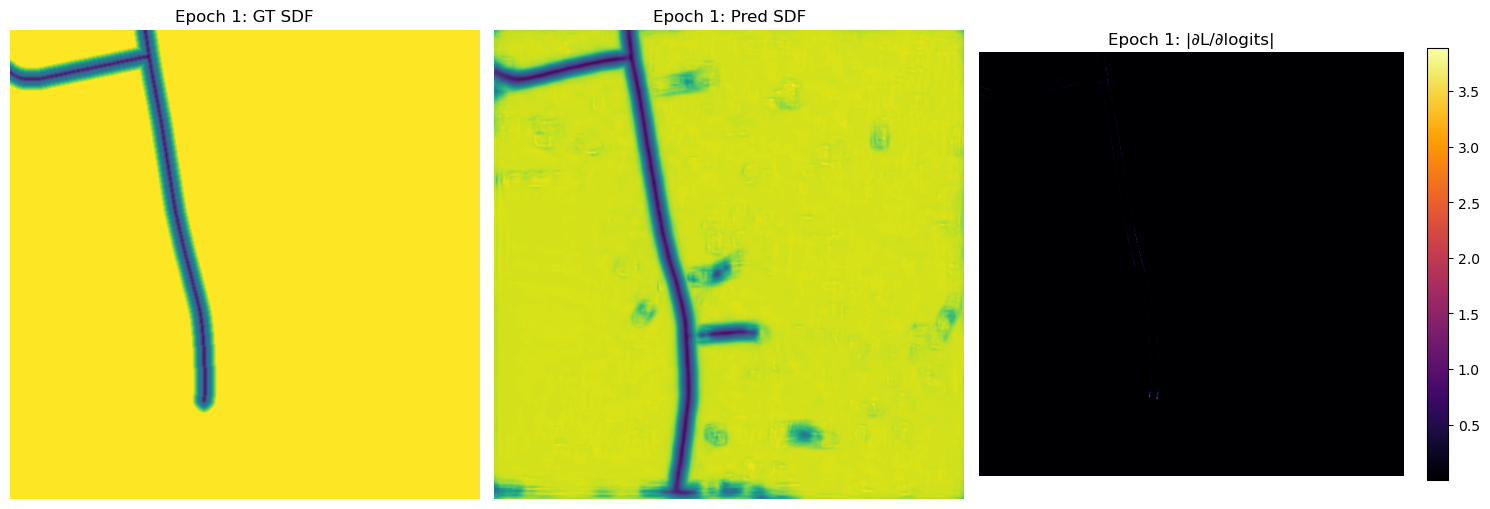

Epoch 002 | Loss 14.4536 | APLS 0.5339


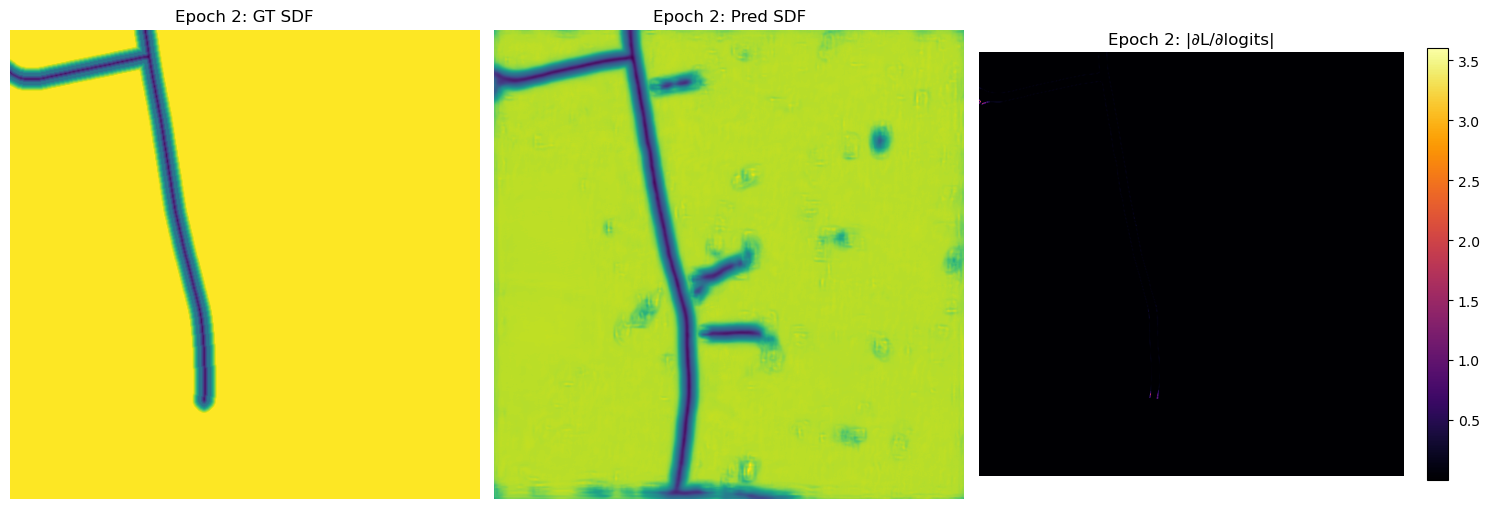

Epoch 003 | Loss 5.2382 | APLS 0.6935


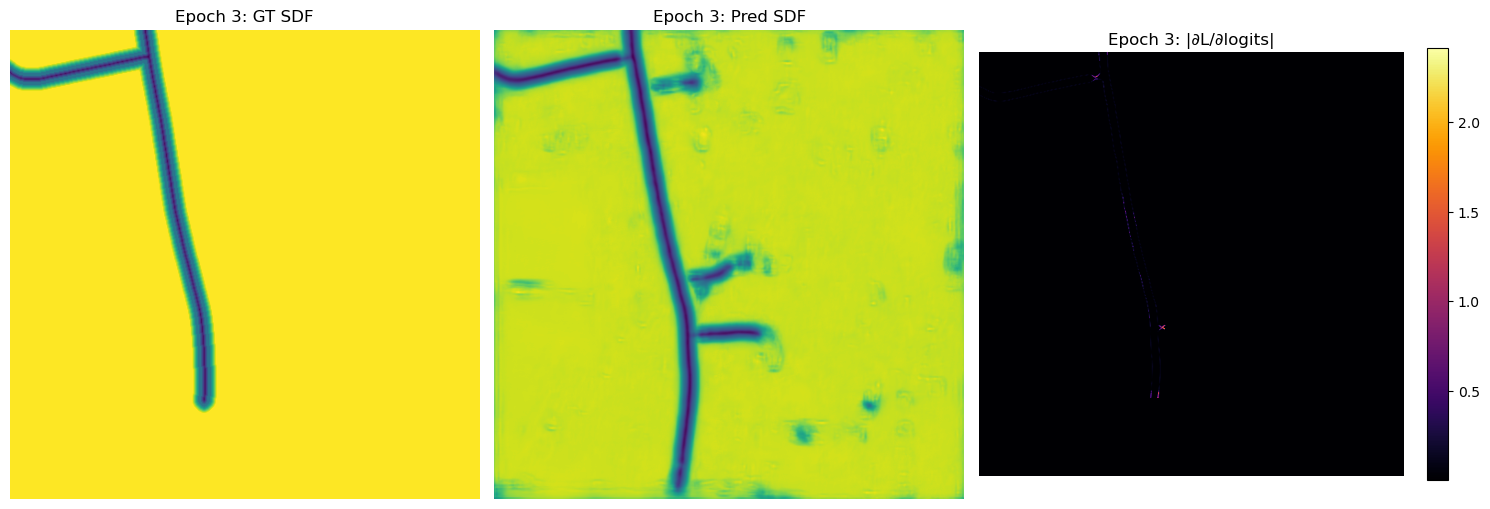

Epoch 004 | Loss 7.6747 | APLS 0.0950


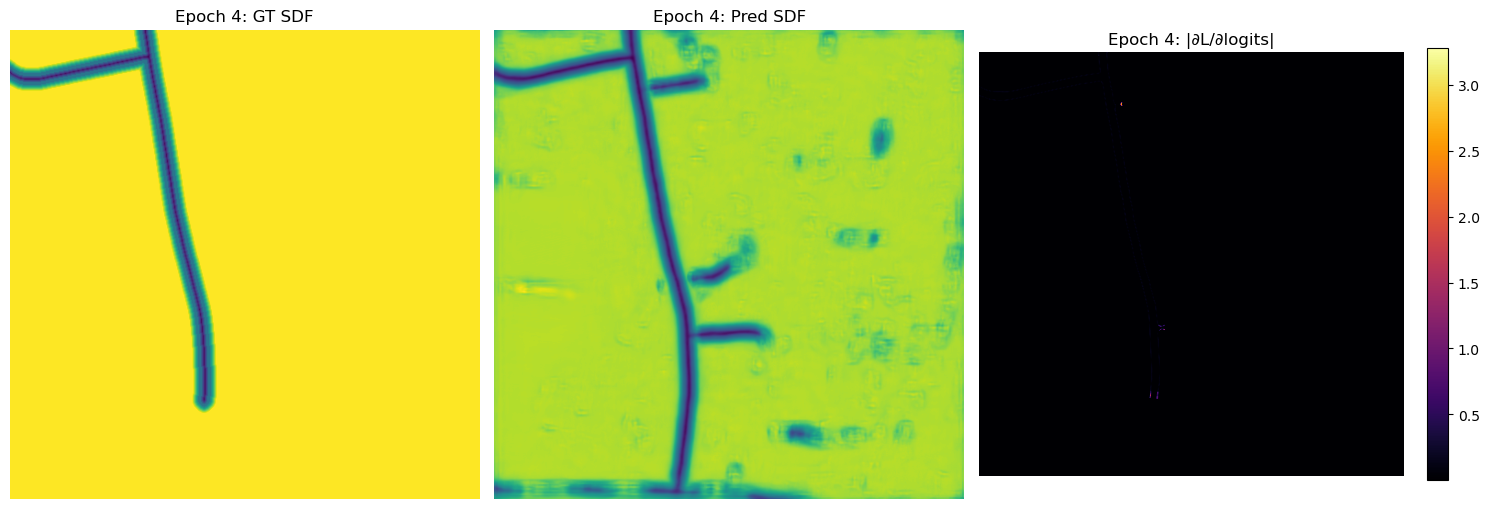

Epoch 005 | Loss 12.0102 | APLS 0.3574


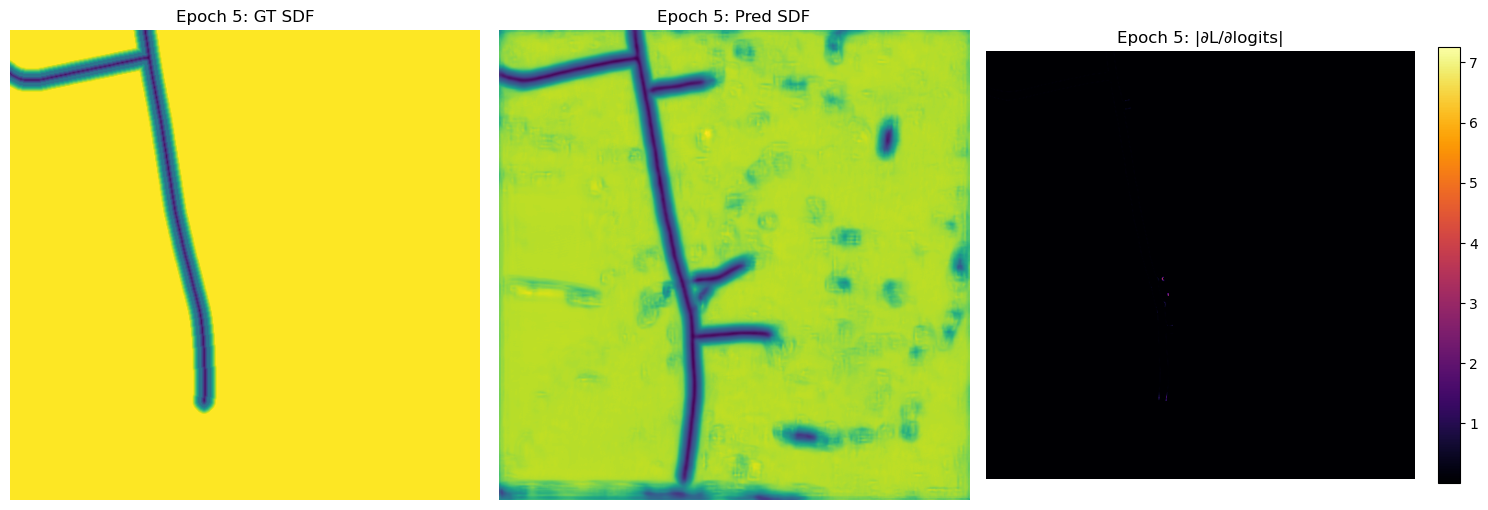

Epoch 006 | Loss 43.0855 | APLS 0.0752


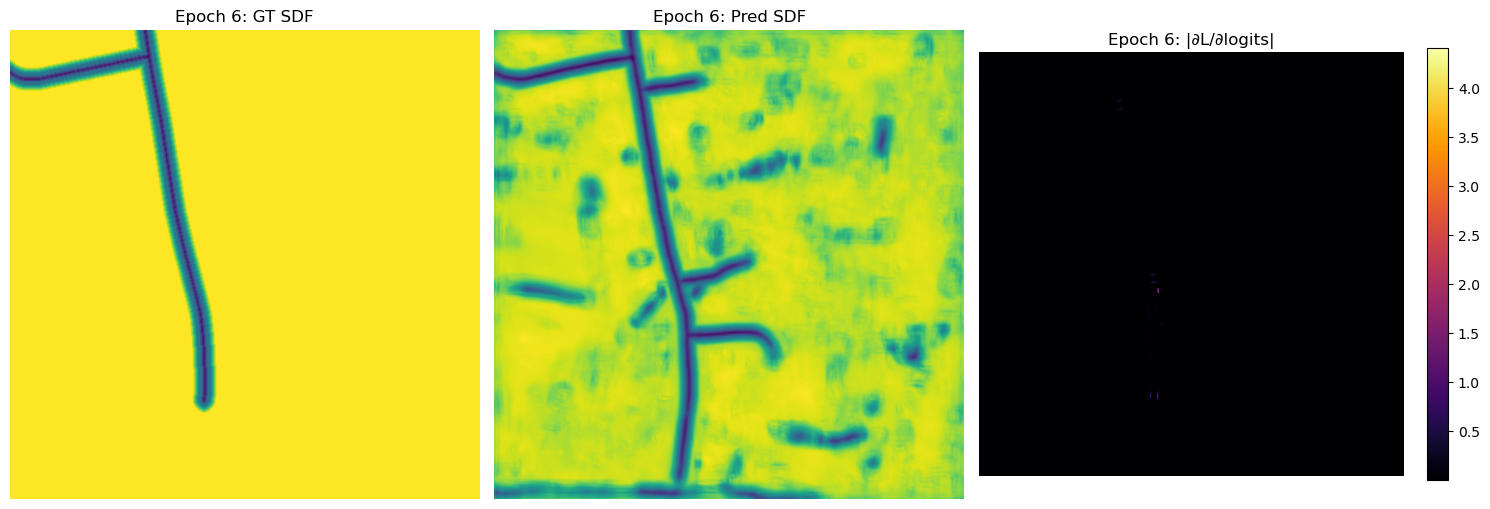

Epoch 007 | Loss 49.4595 | APLS 0.0459


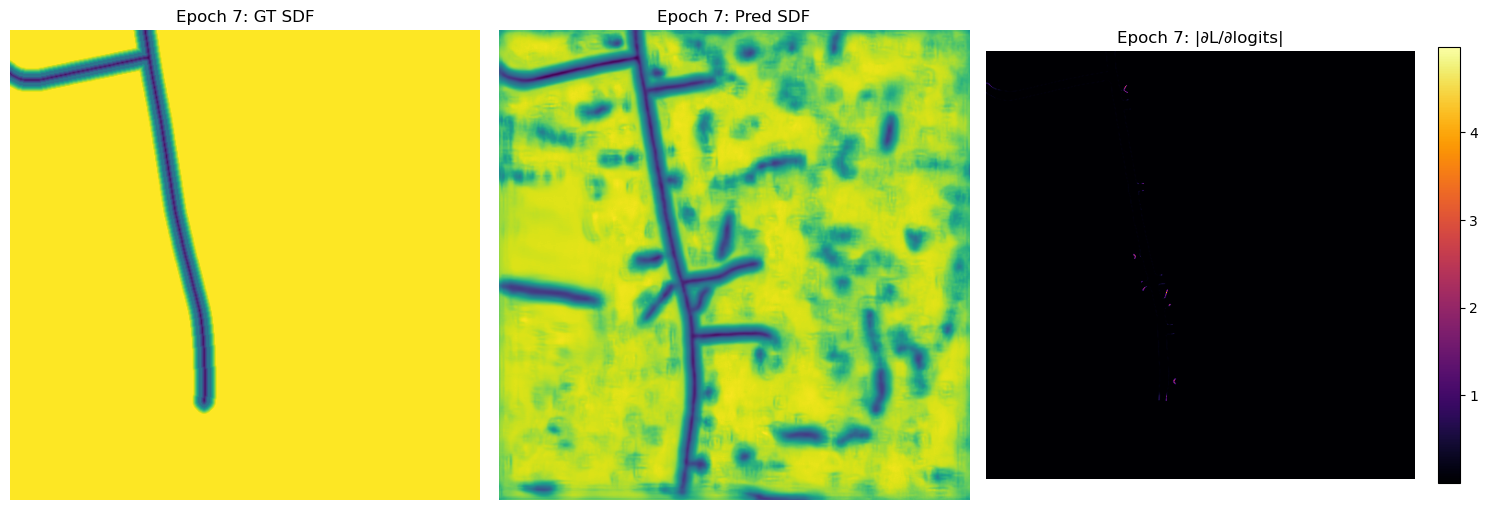

Epoch 008 | Loss 68.9465 | APLS 0.0105


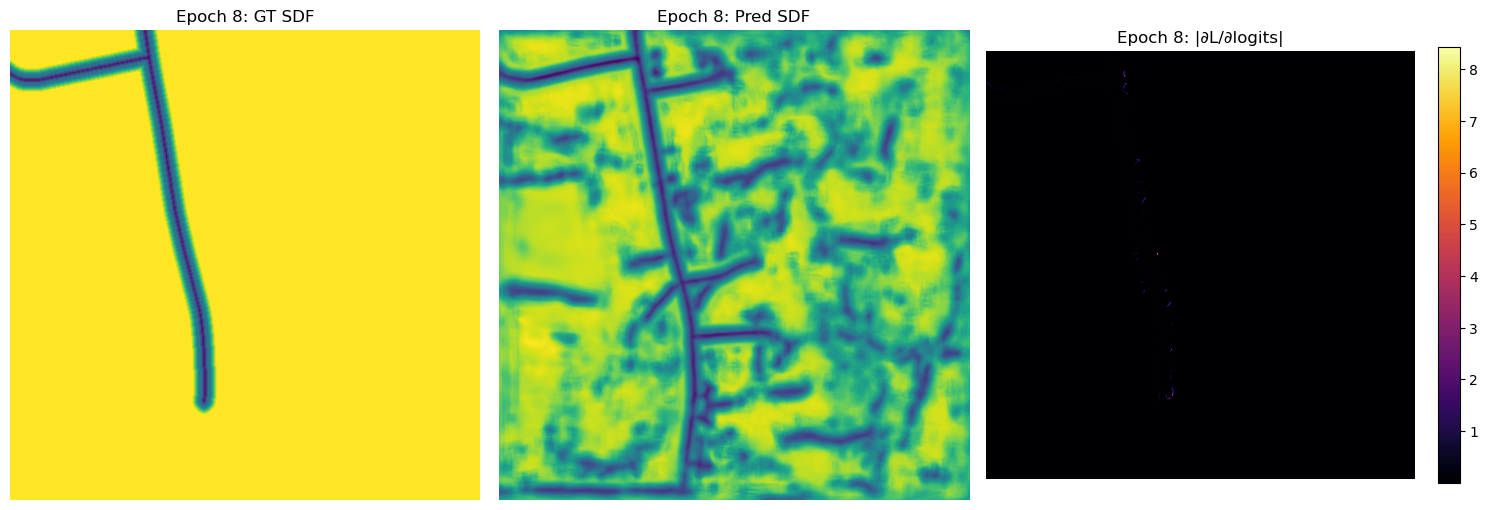

Epoch 009 | Loss 75.2008 | APLS 0.0021


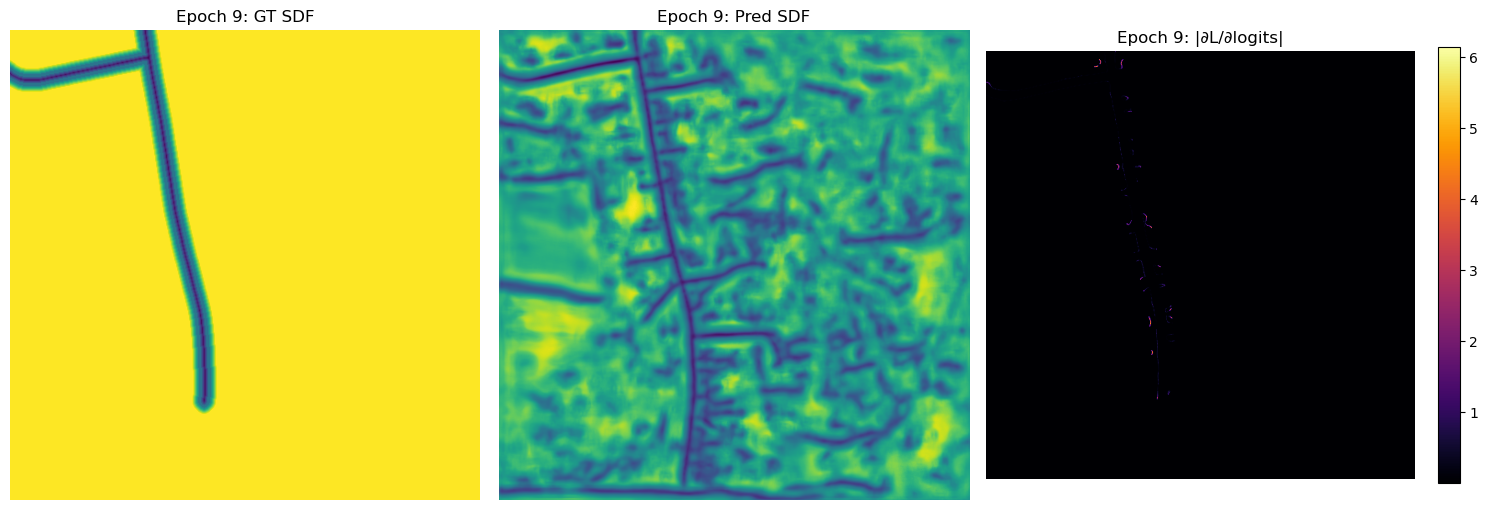

OutOfMemoryError: CUDA out of memory. Tried to allocate 94.00 MiB. GPU 0 has a total capacity of 5.64 GiB of which 94.44 MiB is free. Including non-PyTorch memory, this process has 5.52 GiB memory in use. Of the allocated memory 5.36 GiB is allocated by PyTorch, and 54.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Smoke‑test training loop on two fixed datapoints (100 epochs), no augmentations
# ─────────────────────────────────────────────────────────────────────────────
import os
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

from core.general_dataset.base import GeneralizedDataset
from core.general_dataset.collate import worker_init_fn
from core.utils import yaml_read
from models.base_models import UNet
from metrics.apls import APLS
from IPython.display import display
%matplotlib inline

# ─────────────────────────────────────────────────────────────────────────────
# Config paths & hyperparameters
# ─────────────────────────────────────────────────────────────────────────────
DATASET_YAML = "./configs/dataset/mass_test.yaml"
MODEL_YAML   = "./configs/model/baseline.yaml"
CKPT_IN      = "/home/ri/Desktop/Projects/Codebase/AllFayzad/sdf-first-run/epoch002999.ckpt"

NUM_EPOCHS   = 100
LR           = 1e-4
NUM_WORKERS  = 0
CROP_H, CROP_W = 512, 512

# ─────────────────────────────────────────────────────────────────────────────
# Helpers
# ─────────────────────────────────────────────────────────────────────────────
def make_cfg(cfg, split):
    c = cfg.copy()
    c["split"] = split
    if split in ("valid", "test"):
        c["augmentations"] = []
    return c

def center_crop(x: torch.Tensor, crop_h: int, crop_w: int) -> torch.Tensor:
    _, _, H, W = x.shape
    top  = (H - crop_h) // 2
    left = (W - crop_w) // 2
    return x[:, :, top:top+crop_h, left:left+crop_w]

# ─────────────────────────────────────────────────────────────────────────────
# Device
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# Build dataset (valid split → no augmentations)
# ─────────────────────────────────────────────────────────────────────────────
raw_cfg = yaml_read(DATASET_YAML)
fixed_ds = GeneralizedDataset(make_cfg(raw_cfg, "valid"))
smoke_ds = Subset(fixed_ds, indices=[0, 1])
smoke_dl = DataLoader(
    smoke_ds,
    batch_size=2,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    worker_init_fn=worker_init_fn,
)

# ─────────────────────────────────────────────────────────────────────────────
# Model, loss, metric, optimizer
# ─────────────────────────────────────────────────────────────────────────────
model_cfg = yaml_read(MODEL_YAML)["params"]
model     = UNet(**model_cfg).to(device)

if os.path.isfile(CKPT_IN):
    ckpt = torch.load(CKPT_IN, map_location=device)
    state = ckpt.get("state_dict", ckpt)
    state = {k.replace("model.", ""): v for k, v in state.items()}
    state = {k: v for k, v in state.items() if k in model.state_dict()}
    model.load_state_dict(state, strict=False)
    print(f"Loaded {len(state)} tensors from checkpoint.")

loss_fn = ChamferBoundarySDFLoss(
    pixel_weight=1.0,
    chamfer_weight=1.0,
    update_scale=1.0,
    dist_threshold=8,
).to(device)

apls_fn = APLS(
    data_dim=2, threshold=0, angle_range=(135,225),
    max_nodes=1000, max_snap_dist=4, allow_renaming=True,
    min_path_length=10, greater_is_road=False,
)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ─────────────────────────────────────────────────────────────────────────────
# Training loop with inline plotting (100 epochs)
# ─────────────────────────────────────────────────────────────────────────────
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    optimizer.zero_grad()

    # get batch
    batch = next(iter(smoke_dl))
    x = center_crop(batch["image_patch"], CROP_H, CROP_W).to(device, non_blocking=True)
    y = center_crop(batch["sdf_patch"],   CROP_H, CROP_W).to(device, non_blocking=True)

    # forward
    logits = model(x)                # shape [B,1,H,W]
    logits.retain_grad()             # keep grad on this tensor
    loss = loss_fn(logits, y)

    # backward (populates logits.grad)
    loss.backward()

    # step
    optimizer.step()

    # metric
    with torch.no_grad():
        batch_apls = apls_fn(logits, y)

    print(f"Epoch {epoch:03d} | Loss {loss.item():.4f} | APLS {batch_apls.item():.4f}")

    # prepare numpy arrays
    gt_sdf    = y[0,0].cpu().numpy()
    pred_sdf  = logits[0,0].detach().cpu().numpy()
    grad_map  = logits.grad[0,0].abs().cpu().numpy()  # |∂L/∂logits|

    # 1×3 row: GT SDF, Pred SDF, |∂L/∂logits|
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(gt_sdf, cmap="viridis")
    ax1.set_title(f"Epoch {epoch}: GT SDF")
    ax1.axis("off")

    ax2.imshow(pred_sdf, cmap="viridis")
    ax2.set_title(f"Epoch {epoch}: Pred SDF")
    ax2.axis("off")

    im3 = ax3.imshow(grad_map, cmap="inferno")
    ax3.set_title(f"Epoch {epoch}: |∂L/∂logits|")
    ax3.axis("off")
    fig.colorbar(im3, ax=ax3, fraction=0.046)

    plt.tight_layout()
    display(fig)
    plt.close(fig)

    # cleanup
    torch.cuda.empty_cache()
    gc.collect()
